### Instituto Tecnológico de Costa Rica (ITCR)
### Escuela de Computación
### Curso: Inteligencia Artificial
 
### Tercer tarea programada 2022-I

Profesora: María Auxiliadora Mora


# Estudiantes
Roy Chavarría Garita - 2018034199 \
Jonder Hernández Gutiérrez - 2018203660




# Sección 1. Redes neuronales convolucionales.

## Problema

Realizar el entrenamiento de un modelo utilizando redes convolucionales utilizando imágenes de animales para poder predecir a cuál animal corresponde dicha imagen. Se desea que dada una imagen de un animal dentro del conjunto de datos, de una buena predicción de cuál animal es.


## Objetivo
1. Poner en práctica habilidades de investigación y documentación de resultados. 
2. Aplicar el conocimiento teórico sobre aprendizaje profundo en la implementación de
un ejemplo aplicado a la clasificación de imágenes.
3. Experimentar con el flujo completo de trabajo requerido en proyectos de
aprendizaje automático para realizar análisis de sentimientos a partir de datos en
lenguaje natural.
4. Fortalecer capacidades en los estudiantes en el uso de bibliotecas de aprendizaje
automático como PyTorch y otras.

## Descripción de datos
Es un conjunto de carpetas en donde cada carpeta tiene imágenes de un animal determinado. En total son 90 animales de varios reinos. Cada carpeta tiene varias imágenes con diferentes entornos que contiene al animal. Este conjunto de datos se puede descargar del siguiente enlace: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

In [1]:
#Instalo si no existe la librería matplotlib, torch y torchvision
!pip install numpy matplotlib torch torchvision

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [3]:
#Bibliotecas
import torch
import torchvision

# Para graficar
%matplotlib inline
import matplotlib.pyplot as plt

#Bibliotecas generales
import torchvision.transforms as transforms

# Redes neuronales
import torch.nn as nn
import torch.nn.functional as F

# Pérdida y optimización
import torch.optim as optim

#Para los datos del modelo
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import random_split
import numpy as np

#Bibliotecas ejercicio 2
import pandas as pd
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## Cargar, normalizar y explorar los datos

Pasos para cargar conjunto de datos: 

1. Descargar y descomprimir el archivo descargado del enlace: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/download

2. Agregar la carpeta descomprimida dentro de la carpeta donde se encuentra este jupyter.

In [3]:
# Carga de los datos divididos en datos de entrenamiento y validación.
# Normaliza la imagen pasa de una imagen normal a una donde se nota más las lineas
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

#Conjunto de datos que contienen las imágenes de los animales
dataset = ImageFolder('archive/animals/animals', transform=transform)
#Nombre de las clases o animales
classes = dataset.classes
data_loader = DataLoader(dataset, batch_size=20, shuffle=True)

In [4]:
# Para mostar las dimensiones de la imagen
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


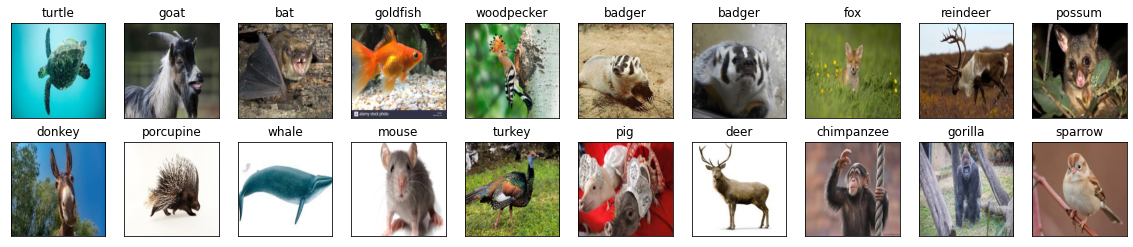

In [5]:
#Muestro mis primeras 20 imágenes dentro de mi datos
def imshow(img):
    #Recibe la imagen
    img = img / 2 + 0.5 
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
dataiter = iter(data_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Cálculo de registros por clase

In [6]:
#Calculamos la cantidad de registros por clase para saber si están balanceadas
labels = {}
for label in classes:
    labels[label] = 0
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
for data in data_loader:
    img, label = data
    labels[classes[label.item()]] += 1
print(labels)

{'antelope': 60, 'badger': 60, 'bat': 60, 'bear': 60, 'bee': 60, 'beetle': 60, 'bison': 60, 'boar': 60, 'butterfly': 60, 'cat': 60, 'caterpillar': 60, 'chimpanzee': 60, 'cockroach': 60, 'cow': 60, 'coyote': 60, 'crab': 60, 'crow': 60, 'deer': 60, 'dog': 60, 'dolphin': 60, 'donkey': 60, 'dragonfly': 60, 'duck': 60, 'eagle': 60, 'elephant': 60, 'flamingo': 60, 'fly': 60, 'fox': 60, 'goat': 60, 'goldfish': 60, 'goose': 60, 'gorilla': 60, 'grasshopper': 60, 'hamster': 60, 'hare': 60, 'hedgehog': 60, 'hippopotamus': 60, 'hornbill': 60, 'horse': 60, 'hummingbird': 60, 'hyena': 60, 'jellyfish': 60, 'kangaroo': 60, 'koala': 60, 'ladybugs': 60, 'leopard': 60, 'lion': 60, 'lizard': 60, 'lobster': 60, 'mosquito': 60, 'moth': 60, 'mouse': 60, 'octopus': 60, 'okapi': 60, 'orangutan': 60, 'otter': 60, 'owl': 60, 'ox': 60, 'oyster': 60, 'panda': 60, 'parrot': 60, 'pelecaniformes': 60, 'penguin': 60, 'pig': 60, 'pigeon': 60, 'porcupine': 60, 'possum': 60, 'raccoon': 60, 'rat': 60, 'reindeer': 60, 'rhi

## Definición de red convulucional

In [7]:
# Crear el modelo de aprendizaje profundo, se crea una clase 
# que envuelve la clase nn.Module 
class Net(nn.Module):
    def __init__(self):
        # Función para definir e inicializar la red.
        super(Net, self).__init__()
        
        #capa convolucional
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size...
        self.conv1 = nn.Conv2d(3, 6, 3)
        
        #torch.nn.MaxPool2d(kernel_size, stride,...        
        self.pool = nn.MaxPool2d(2, 2) 
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size...
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        #Capas perceptrón del modelo
        self.fc1 = nn.Linear(46656, 120)
        self.fc2 = nn.Linear(120, 84)
        #Salida a 90 clases
        self.fc3 = nn.Linear(84, 90)
        
    def forward(self, x):
        # Aplica el modelo a los datos de entrada.
        # :param
        #   x : datos de la imagen a procesar.
        
        #Pase de la entrada por todas las capas de la red.
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        # Retorna el numero de pixeles total de una imagen
        # :param
        #   x : datos de la imagen a procesar.

        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model = Net()
#Creo un nuevo modelo

import copy
  
# use deepcopy() to deep copy 
model2 = copy.deepcopy(model)

## Definición de hiper-parámetros 

Se utiliza la función de pérdida de entropía cruzada y optimización por descenso de gradiente estocástico (Stochastic Gradient Descent - SGD).

In [8]:
import torch.nn.functional as F

#Funcion de loss
loss_function = F.cross_entropy

#Funcipon de optimización
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Datos de pruebas y validación

Se separa las muestras en datos de entrenamiento y validación

In [9]:
#Defino un tamaño de batch
batch_size = 10

#len(dataset)*0.7+1 y len(dataset)*0.3+1  esto con la funcion piso
#train_set, test_set = random_split(dataset, [3780, 1620])
train_set = ImageFolder('archive/animals/animals', transform=transform)
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=2)

#len(train_set)*0.7+1 y len(train_set)*0.3+1  esto con la funcion piso
#train_set, valid_set = random_split(train_set, [2646, 1134])

#Datos de entrenamiento
test_set = ImageFolder('archive/animals/animals', transform=transform)
test_loader = DataLoader(test_set, batch_size, shuffle=True, num_workers=2)

#print(len(train_loader))

In [10]:
#guardo datos importantes para mostar la gráfica de error
acc_l = []
loss_l = []
val_acc_l = []
val_loss_l = []

In [11]:
from sklearn.metrics import mean_squared_error
#Esta funcion me ayuda a extraer datos para poder graficar la curva de error
#Esta funcion me ayuda a extraer datos para poder graficar la curva de error
def validation_metrics (model_net, valid_dl):
    """Recibe
        -La red o el modelo
        -Un conjunto de datos correctos
    """
    model_net.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, l in valid_dl:
        y = l.long()
        y_hat = model_net(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

## Entreno el modelo

In [12]:
loss_values = []

def train_model(model_net,numEpoch, train,test, loss_function, optimizer):
    """Recibe
        -El modelo o la red
        -Número de épocas
        -Un conjunto de satos para entrenar la red
        -Un conjunto de satos para probar la red
        -La función de pérdida
        -La función de optimización
    """
    # cantidad de ciclos de entrenamiento o épocas
    total = len(train)
    for epoch in range(numEpoch):  
        running_loss = 0.0
        total = 0
        for i, data in enumerate(train,0):
            y = data[1].long()
            # obtener los datos de entrada; 
            # data es una lista de la forma [inputs, labels]
            inputs, labels = data

            # inicializar los parámetros del gradiente.
            optimizer.zero_grad()

            # Se realizan las predicciones con el modelo. 
            # Este código ejecuta el forward de las entradas.
            outputs = model_net(inputs)

            # Se calcula la pérdida utilizando Cross Entropy Loss
            loss = loss_function(outputs, labels)       
            loss.backward()

            #El optimizador realiza las actualizaciones a través del método step().
            optimizer.step()
            #print(i)
            # imprimir estadisticas
            running_loss += loss.item()
            loss_values.append(running_loss)
            total += y.shape[0]
            if i % 100 == 0:    # imprimir mensaje cada 100 mini-batches
                print('[%d, %5d] pérdida: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
                
        #Guardo los datos para graficar la curva de error
        val_loss, val_acc, val_rmse = validation_metrics(model_net, test)
        
        #guardo datos para graficarlos en curva de error
        val_loss_l.append(val_loss)
        val_acc_l.append(val_acc)
        loss_l.append(running_loss / 100)
        acc_l.append(val_rmse)

    print('Fin del entrenamiento')


In [13]:
train_model(model,10, train_loader,test_loader, loss_function, optimizer)
#print(loss_values)

[1,     1] pérdida: 0.045
[1,   101] pérdida: 4.502
[1,   201] pérdida: 4.499
[1,   301] pérdida: 4.499
[1,   401] pérdida: 4.492
[1,   501] pérdida: 4.487
[2,     1] pérdida: 0.045
[2,   101] pérdida: 4.469
[2,   201] pérdida: 4.459
[2,   301] pérdida: 4.437
[2,   401] pérdida: 4.416
[2,   501] pérdida: 4.379
[3,     1] pérdida: 0.042
[3,   101] pérdida: 4.303
[3,   201] pérdida: 4.245
[3,   301] pérdida: 4.210
[3,   401] pérdida: 4.213
[3,   501] pérdida: 4.172
[4,     1] pérdida: 0.039
[4,   101] pérdida: 4.090
[4,   201] pérdida: 4.001
[4,   301] pérdida: 4.049
[4,   401] pérdida: 4.065
[4,   501] pérdida: 4.044
[5,     1] pérdida: 0.035
[5,   101] pérdida: 3.855
[5,   201] pérdida: 3.899
[5,   301] pérdida: 3.917
[5,   401] pérdida: 3.896
[5,   501] pérdida: 3.911
[6,     1] pérdida: 0.035
[6,   101] pérdida: 3.667
[6,   201] pérdida: 3.689
[6,   301] pérdida: 3.669
[6,   401] pérdida: 3.685
[6,   501] pérdida: 3.690
[7,     1] pérdida: 0.038
[7,   101] pérdida: 3.453
[7,   201] p

## Evaluación del modelo con métricas

In [14]:
#Acurrancy
# Se toma todos los datos de prueba y se verifica si el modelo realiza
# bien la predicción para cada uno. 

#Cantidad de imágenes clasificadas correctamente.
correct = 0

#Imágenes totales
total = 0

with torch.no_grad():
    for data in test_loader:
        # Datos de las imágenes y etiquetas
        images, labels = data
        
        # Forward de las imágenes en el modelo.
        outputs = model(images)
        
        # Clase a la que pertece cada imagen
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Exactitud de la red en las 10000 imágenes de prueba: %d %%' % (
    100 * correct / total))

Exactitud de la red en las 10000 imágenes de prueba: 52 %


## Matriz de confusión

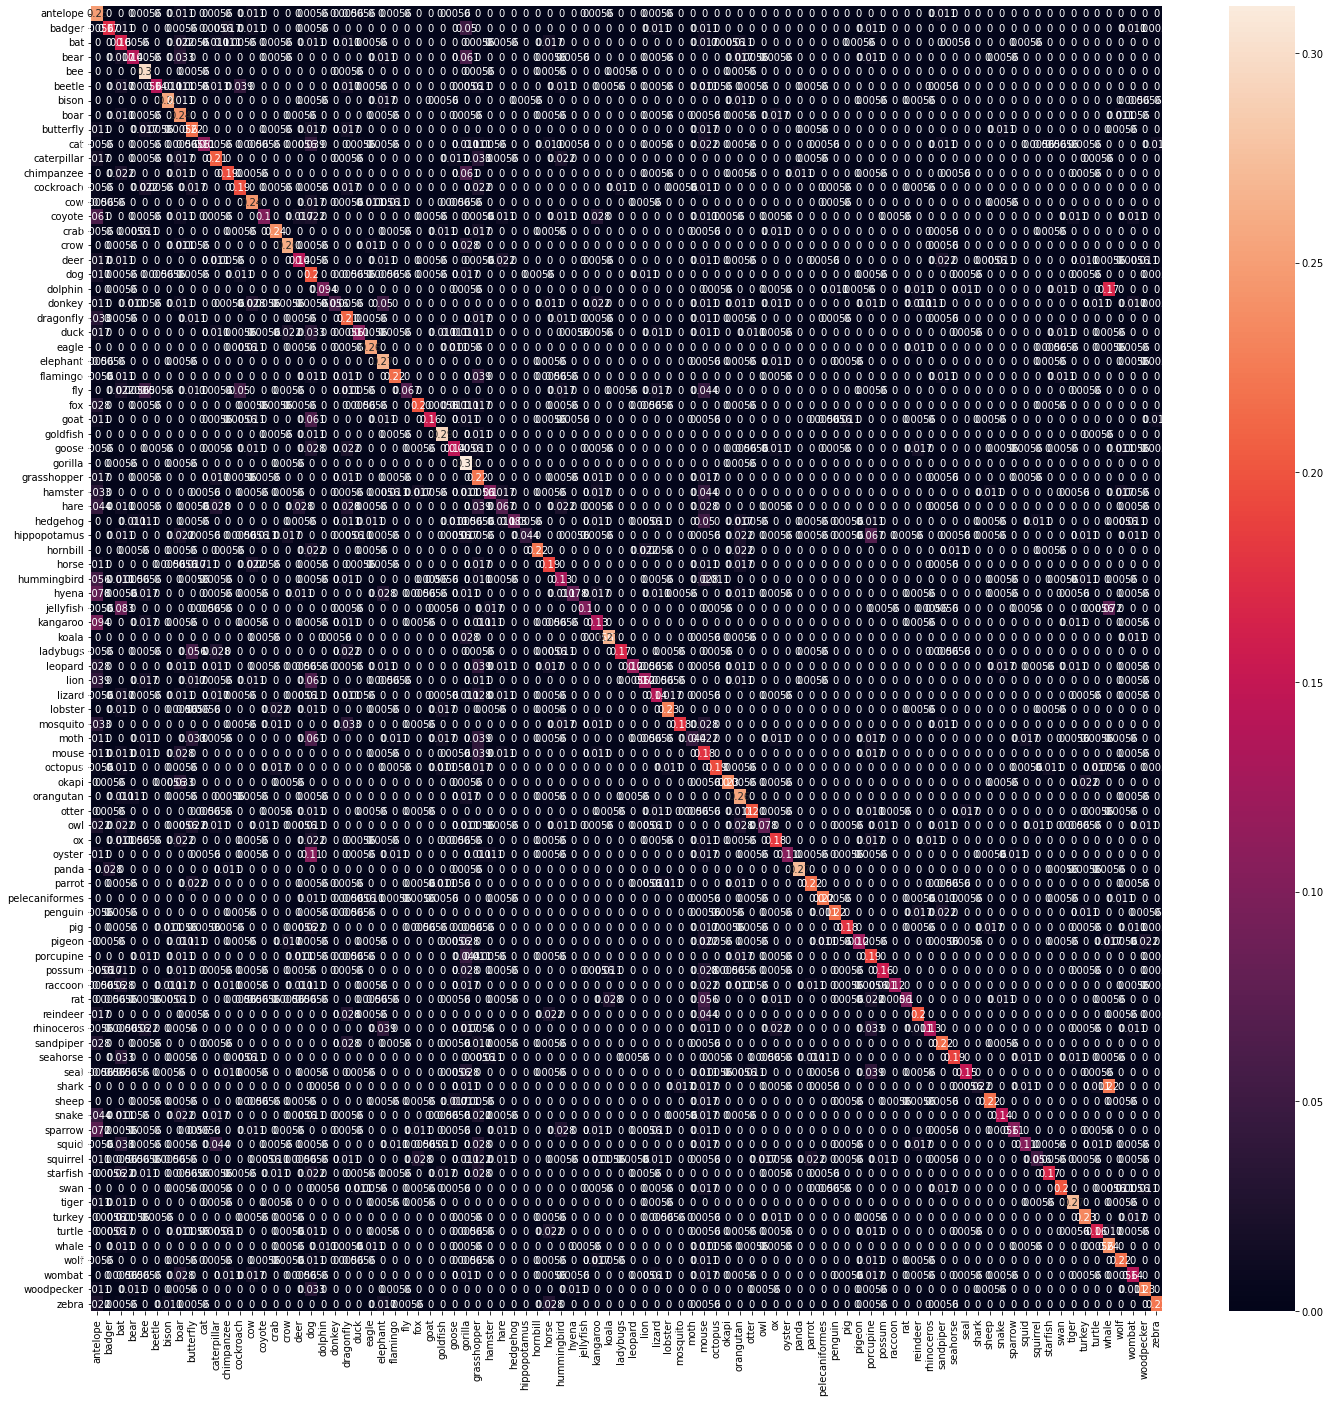

In [15]:
#importo librería para matriz de confución y mostrarla
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

#Itero dentro de los datos de test
for inputs, labels in test_loader:
         # Alimento la red
        output = model(inputs)
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        # Salvo la predicción
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        # Salvo la verdadera
        y_true.extend(labels) 

# Construyo la matriz de confusión
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *30, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (24,24))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

Como se puede observar en la matriz, la mayoría de filas o clases están rellenas con ceros, esto significa que el sistema no tiene muchos problemas al distinguir un animal o clase. Con esta matriz podemos deducir que la red casi no se confunde entre las diferentes clases. En los cuadros que si hay números, aparte de la diagonal, eso significa que la red confundió un animal con otro.

## Gráfica de curva de error

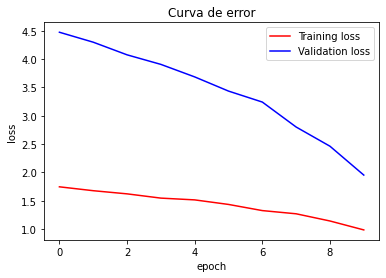

In [16]:
#importo la librería mat plot lib
import matplotlib.pyplot as plt
%matplotlib inline 

#Llamo a los datos guardados cuando estaba entrenando la red
loss = loss_l
val_loss = val_loss_l

epochs = range(len(acc_l))

#Muestro la gráfica
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Curva de error')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

Se puede observar que conforme el algoritmo de entrenamiento va avanzando, la red tiene menos problemas en aprender. Como la gráfica muestra que esa variación se diminuyó al final pero no es suficiente por lo que debo aumentar el número de pochs.

## Mejoras y cambios

- Para mejorar el resultado a la predicción se ajustaron los epochs a 10 y se minimizó el tamaño de la imagen para poder realizar los cálculos más rápidos.
- Otra mejora que se puede realizar es añadir la rotación aleatoria de imágenes.
- Se mejorará el sistema utilizando transfering learning en donde tomamos el modelo ya entrenado y le modificamos la última capa ajustandola a nuestro problema.

## Aplicación de Cambios (Técnica de tranferencia)



In [17]:
from torchvision import models
#Tecnica de transferencia para una red neuronal

#Se crea el modelo
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        #90 son la cantidad de targets
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features,90)
                                   
    def forward(self, image):
        output = self.resnet(image)
        return output

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Classifier().to(device)

criterion2 = nn.CrossEntropyLoss()
params = model.resnet.fc.parameters()
optimizer2 = optim.Adam(params, lr=0.003)

#Entreno el modelo
train_model(model,2, train_loader,test_loader, criterion2, optimizer2)

[1,     1] pérdida: 0.049
[1,   101] pérdida: 3.566
[1,   201] pérdida: 1.497
[1,   301] pérdida: 1.112
[1,   401] pérdida: 1.008
[1,   501] pérdida: 0.846
[2,     1] pérdida: 0.003
[2,   101] pérdida: 0.332
[2,   201] pérdida: 0.288
[2,   301] pérdida: 0.331
[2,   401] pérdida: 0.329
[2,   501] pérdida: 0.297
Fin del entrenamiento


In [19]:
#función para calcular el acurrancy de nuestro nuevo modelo
def global_accuracy(model, test_loader):
    #Recibe el modelo y el conjunto de datos de prueba
    correct = 0
    total = 0
    model.to("cpu")
    dataiter = iter(test_loader)
    with torch.no_grad():
        for data in dataiter:
            img, label = data
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
    print(f"Accuracy: {100 * correct / total}")

In [20]:
# Observamos que tanto mejoró el entrenamiento calculando el acurrancy
global_accuracy(model, test_loader)

Accuracy: 91.88888888888889


## Aplicación de Cambios (RandomRotation y Flip)


In [21]:
#Defino un tamaño de batch
batch_size = 60
transform2 = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(), #Agrego voltear imagen
                                transforms.RandomRotation(10),     #Agrego rotación aleatoria
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

#Conjunto de datos que contienen las imágenes de los animales
datos2 = ImageFolder('archive/animals/animals', transform=transform2)
test_loader2 = DataLoader(datos2, batch_size, shuffle=True, num_workers=2)
train_loader2 = DataLoader(datos2, batch_size, shuffle=True, num_workers=2)

In [22]:
#Funcion de loss
loss_function2 = F.cross_entropy

#Funcipon de optimización
optimizer2 = torch.optim.SGD(model.parameters(), lr=0.0001)

In [23]:
#entreno el nuevo modelo
#guardo para mostar la gráfica de error
acc_l = []
loss_l = []
val_acc_l = []
val_loss_l = []

#Entreno el modelo con las nuevas transformaciones
train_model(model2, 10, train_loader,test_loader, loss_function2, optimizer2)

[1,     1] pérdida: 0.045
[1,   101] pérdida: 4.505
[1,   201] pérdida: 4.500
[1,   301] pérdida: 4.507
[1,   401] pérdida: 4.499
[1,   501] pérdida: 4.500
[2,     1] pérdida: 0.045
[2,   101] pérdida: 4.499
[2,   201] pérdida: 4.501
[2,   301] pérdida: 4.501
[2,   401] pérdida: 4.504
[2,   501] pérdida: 4.505
[3,     1] pérdida: 0.045
[3,   101] pérdida: 4.501
[3,   201] pérdida: 4.499
[3,   301] pérdida: 4.503
[3,   401] pérdida: 4.502
[3,   501] pérdida: 4.505
[4,     1] pérdida: 0.045
[4,   101] pérdida: 4.501
[4,   201] pérdida: 4.502
[4,   301] pérdida: 4.504
[4,   401] pérdida: 4.499
[4,   501] pérdida: 4.503
[5,     1] pérdida: 0.045
[5,   101] pérdida: 4.502
[5,   201] pérdida: 4.502
[5,   301] pérdida: 4.503
[5,   401] pérdida: 4.503
[5,   501] pérdida: 4.503
[6,     1] pérdida: 0.045
[6,   101] pérdida: 4.500
[6,   201] pérdida: 4.504
[6,   301] pérdida: 4.499
[6,   401] pérdida: 4.505
[6,   501] pérdida: 4.501
[7,     1] pérdida: 0.045
[7,   101] pérdida: 4.500
[7,   201] p

In [24]:
# Observamos que tanto mejoró el entrenamiento calculando el acurrancy
global_accuracy(model2, test_loader)

Accuracy: 0.8148148148148148


# Conclusiones
- Se puede mejorar el entrenamiento de una red convulusional agregando más opciones al transforms, como por ejemplo rotaciones aleatorias de la imagen

- El tamaño de la imagen mejora la velocidad del algoritmo pero no mejora tanto la predicción.

- Entrenar una red para predecir imágenes consume mucha memoria y recursos, por lo que se debe utilizar los parámetros adecuados para mejorar la velocidad.

- Es recomendable guardar el modelo para no tener que estar entrenandolo cada vez que se vaya a utilizar. Guardarlo no solo nos sirve para utilizarlo sino también para mejorarlo como se hizo anterioromente con transfering learning

## Referencias

- Cómo aplicar una CNN de PyTorch a sus imágenes. manualestutor. (2022). Retrieved 17 May 2022, from
https://manualestutor.com/aprendizaje-automatico/como-aplicar-una-cnn-de-pytorch-a-sus-imagenes/.
- Clasificación de imágenes en Pytorch | ENTRENA EN LA NUBE. The Machine Learners. (2022). Retrieved 17 May 2022, from https://www.themachinelearners.com/clasificacion-imagenes-pytorch/.
- How to create a confusion matrix in PyTorch. Medium. (2022). Retrieved 17 May 2022, from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7.
- Animal Image Dataset (90 Different Animals). Kaggle.com. (2022). Retrieved 17 May 2022, from https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals.
- animal-image-classifications/I_notebook.ipynb at master · imamun93/animal-image-classifications. GitHub. (2022). Retrieved 18 May 2022, from https://github.com/imamun93/animal-image-classifications/blob/master/I_notebook.ipynb.

# Sección 2. Análisis de sentimientos con redes neuronales recurrentes LSTM utilizando Pytorch. 

## Problema

Se desea que, dado un comentario de crítica acerca de la experiencia vivida dentro de un hotel determinado, predecir la calificación correspondiente a ese comentario. La calificación va del 1 al 5 siendo 5 la mejor calificación y 1 la peor calificación. 

## Objetivo
1. Poner en práctica habilidades de investigación y documentación de resultados.
2. Aplicar el conocimiento teórico sobre redes neuronales recurrentes LSTM.
3. Experimentar con el flujo completo de trabajo requerido en proyectos de
aprendizaje automático para realizar análisis de sentimientos a partir de datos en
lenguaje natural.
4. Fortalecer capacidades en los estudiantes en el uso de bibliotecas de aprendizaje
automático como PyTorch y otras.

## Descripción de datos

Los datos vienen dentro de un archivo csv que contiene 2 columnas, la primer columna es el comentario que se le realizó a una hotel determianda y la segunda columna trae la evaluación que se le dió al hotel. La evaluación que se le puede dar al comentario es de un rango del 1 al 5.

Los datos utilizado en el ejemplo estás disponibles en https://www.kaggle.com/code/wiktorbrk/trip-advisor-reviews-sentiment-analysis/data. La descripción del sitio indica "este es un conjunto de datos que contiene un comentario hacia un hotel y una calificación por parte del usuario"

El conjunto de datos consta de las siguientes columnas:

Review: Un texto que es el comentario
Rating: Numero positivo del 1 al 5 que indica la calificación al hotel.

## Carga y preparación de datos

Pasos para cargar conjunto de datos: 

1. Descargar y descomprimir el archivo descargado del enlace: https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data

2. Agregar el archivo descomprimido dentro de la carpeta donde se encuentra este jupyter.

In [4]:
# Leer los datos de ejemplos
reviews = pd.read_csv("tripadvisor_hotel_reviews.csv")
#print(reviews.shape)
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
#Cambio de la numeración de la clasificaciones de 0 a 4
zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
reviews['Rating'] = reviews['Rating'].apply(lambda x: zero_numbering[x])

## Estadísticas de los datos

In [6]:
# Estadísticas de los datos
pd.set_option('display.float_format', lambda x: '%.2f' % x)
reviews.describe()

,Rating
count,20491.00
mean,2.95
std,1.23
min,0.00
25%,2.00
50%,3.00
75%,4.00
max,4.00


In [7]:
# Verificación de qué tan bien balanceadas están las clases.
Counter(reviews['Rating'])

Counter({3: 6039, 1: 1793, 2: 2184, 4: 9054, 0: 1421})

## Creación definición de modelo y definición de sus datos

In [8]:
# Tokenización: proceso de separar un fragmento de texto en 
#  unidades más pequeñas llamadas tokens. 
#  Los tokens pueden ser palabras, caracteres o sub-palabras.
tok = spacy.blank("en")

def tokenize (text):
    """Recibe
        -Texto
        
        Retorna
        - Una lista de tokens en donde cada token representa una palabra o el texto separado por espacio
    """
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [9]:
# Se cuenta la cantidad de ocurrencias de cada token 
# en el corpus.

#count number of occurences of each word
counts = Counter()
for index, row in reviews.iterrows():
    counts.update(tokenize(row['Review']))

In [10]:
# Se crea el vocabulario
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

#print(vocab2index)  

In [11]:
def encode_sentence(text, vocab2index, N=70):
    """
    Codificación de una oración antes de ser utilizada por el modelo. 
    Parámetros:
       text: el texto a procesar
       vocab2index: diccionario con el vocabulario a utilizar. 
       N: largo máximo
    """
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    
    # El get en diccionario permite definir un valor si un item no existe ("UNK").  
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    
    # Largo máximo del resultado.
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

reviews['encoded'] = reviews['Review'].apply(lambda x: np.array(encode_sentence(x,vocab2index ), dtype=object))
#print(reviews.head())

In [12]:
# Extracción de características y target.
X = list(reviews['encoded'])
y = list(reviews['Rating'])

# División de datos de entrenamiento y validación
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [13]:
# Definción de la clase Dataset para manejo de los datos
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [14]:
class LSTM_fixed_len(torch.nn.Module) :
    """
    Clase para realizar la clasificación de las oraciones. 
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size=5) :
        """
        Inicialización de la clase.
        Parámetros:
           embedding_dim: dimesionalidad del vector de palabras. 
           hidden_dim: dimensión de la capa oculta de la red. 
           vocab_size: tamaño del vocabulario.  
           tagset_size: número de clases.
        """
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, tagset_size)
        
        # Durante el entrenamiento, pone a cero aleatoriamente algunos de los elementos 
        # del tensor de entrada con probabilidad p utilizando muestras de una 
        # distribución de Bernoulli. Esta ha demostrado ser una técnica eficaz para la regularización.
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [15]:
vocab_size = len(words)
#print(vocab_size)
#INstancia o creación de modelo
model_fixed =  LSTM_fixed_len(vocab_size, 30, 50)

In [16]:
import torch.nn.functional as F

#Funcion de loss
loss_function = F.cross_entropy

#Funcipon de optimización
parameters = filter(lambda p: p.requires_grad, model_fixed.parameters())
optimizer = torch.optim.SGD(parameters, lr=0.001)

## Datos de pruebas y validación

In [17]:
# Creación de los datasets de entrenamiento y validación

batch_size = 5000

#Creo el conjunto de datos de entrenamiento y validación
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

#Datos de entrenamiento y validación
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [18]:
#guardo para mostar la gráfica de error
acc_l = []
loss_l = []
val_acc_l = []
val_loss_l = []

## Entrenar el modelo

In [19]:
#Esta funcion me ayuda a extraer datos para poder graficar la curva de error
def validation_metrics (model_net, valid_dl):
    """Recibe
        -La red o modelo
        -COnjunto de datos válidos
        
        Retorna
        -Datos para gráfica de curva de error
    """
    model_net.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model_net(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [20]:
def train_model(model,train_dl,epochs):
    """
    Entrenamiento del modelo utilizando PyTorch.
    Recibe
        -modelo, datos de entrenamiento y número de epochs
    """
    res = []
    #optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            
            optimizer.zero_grad()
            model.zero_grad()
            loss = loss_function(y_pred, y)
            loss.backward()
            optimizer.step()
            
            sum_loss += loss.item()*y.shape[0]
            #loss_values.append(loss_l)
            total += y.shape[0]
            
            res=y       
        
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        
        #guardo datos para graficarlos en curva de error
        val_loss_l.append(val_loss)
        val_acc_l.append(val_acc)
        loss_l.append(sum_loss/total)
        acc_l.append(val_rmse)
        
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
    print("Termina el entrenamiento")
    return res,val_acc

In [21]:
prediccion, acc = train_model(model_fixed,train_dl, epochs=5)

train loss 1.613, val loss 1.612, val accuracy 0.117, and val rmse 2.897
Termina el entrenamiento


## Gráfica de curva de error

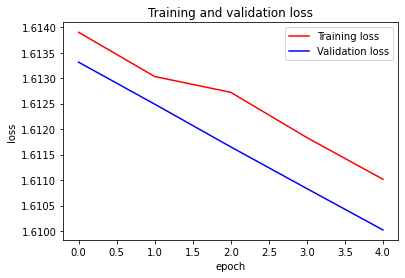

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline 

epochs = range(len(acc_l))

loss = loss_l
val_loss = val_loss_l

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

Se puede observar que conforme el algoritmo de entrenamiento va avanzando, la red tiene menos problemas en aprender. Como la gráfica muestra que esa variación va disminuyendo pero no es suficiente por lo que debo aumentar el número de pochs.

## Evaluación del modelo - Acurrancy

In [23]:
print("Acurrancy: ", acc*100)
#Se puede observar que la presición del algoritmo es muy baja

Acurrancy:  tensor(11.9785)


## Evaluación del modelo - Matriz de confusión

Text(24.0, 0.5, 'Actual')

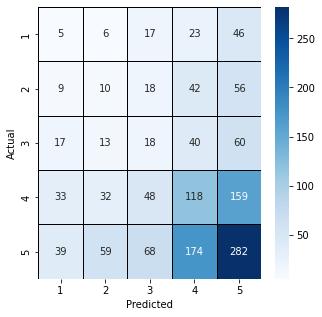

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#y_pred = model_fixed(a,c)
#una lista con calificaciones del 1 al 5

y_true = y_train[15000:] #los últimos 1392 son los resultados correctos de los targets
y_pred = prediccion

#y_pred = model(x, l)
#y_pred = y_train

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['1','2','3','4','5'], 
            yticklabels = ['1','2','3','4','5'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

Observando la matriz de confusión se puede deducir que el modelo no está muy bien entrenado, ya que se confunde entre clases. Otra observación es que aunque el modelo no esté muy bien entrenado, predice correctamente la mayoría de manera muy buena.

## Mejoras al modelo - Balanceo de carga (Clase con menor datos)

In [25]:
#guardo para mostar la gráfica de error
acc_l = []
loss_l = []
val_acc_l = []
val_loss_l = []

In [26]:
#Balanceo las clases del csv utilizando la clase que tiene menos datos

df = pd.read_csv("tripadvisor_hotel_reviews.csv")

a = pd.DataFrame(df[df.Rating == 1][:1420])
b = pd.DataFrame(df[df.Rating == 2][:1420])
c = pd.DataFrame(df[df.Rating == 3][:1420])
d = pd.DataFrame(df[df.Rating == 4][:1420])
e = pd.DataFrame(df[df.Rating == 5][:1420])

frames = [a,b,c,d,e]
result = pd.concat(frames)

#Cambio de la numeración de la clasificaciones de 0 a 4
zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
result['Rating'] = result['Rating'].apply(lambda x: zero_numbering[x])

# Verificación de qué tan bien balanceadas están las clases.
Counter(result['Rating'])

Counter({0: 1420, 1: 1420, 2: 1420, 3: 1420, 4: 1420})

In [27]:
result['encoded'] = result['Review'].apply(lambda x: np.array(encode_sentence(x,vocab2index ), dtype=object))
# Extracción de características y target.
X2 = list(result['encoded'])
y2 = list(result['Rating'])

# División de datos de entrenamiento y validación
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size=0.5)

In [28]:
# Creación de los datasets de entrenamiento y validación

batch_size = 5000

train_ds2 = ReviewsDataset(X_train2, y_train2)
valid_ds2 = ReviewsDataset(X_valid2, y_valid2)

#Datos de entrenamiento y validación
train_dl2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
val_dl2 = DataLoader(valid_ds2, batch_size=batch_size)

In [29]:
model_fixed2 =  LSTM_fixed_len(len(words),30,60)

In [30]:
prediccion2, acc2 = train_model(model_fixed2,train_dl2, epochs=20)

train loss 1.619, val loss 1.652, val accuracy 0.150, and val rmse 1.750
train loss 1.619, val loss 1.652, val accuracy 0.150, and val rmse 1.750
train loss 1.619, val loss 1.652, val accuracy 0.150, and val rmse 1.750
train loss 1.619, val loss 1.652, val accuracy 0.150, and val rmse 1.750
Termina el entrenamiento


In [31]:
# Validación del modelo 
print ("Exactitud: ", acc2 * 100, "%")

Exactitud:  tensor(15.0281) %


Al principio nuestro modelo nos daba un rendimiento bajo, aunque con esta "mejora" nos haya dado parecido, el entrenamiento lo ha realizado en menos tiempo y con un resultado un poco mejor.

## Mejoras al modelo - (Aumento de epochs)

In [32]:
prediccion3 = train_model(model_fixed,train_dl, epochs=100)

train loss 1.609, val loss 1.608, val accuracy 0.122, and val rmse 2.871
train loss 1.605, val loss 1.604, val accuracy 0.130, and val rmse 2.836
train loss 1.601, val loss 1.600, val accuracy 0.132, and val rmse 2.821
train loss 1.598, val loss 1.597, val accuracy 0.136, and val rmse 2.797
train loss 1.595, val loss 1.593, val accuracy 0.139, and val rmse 2.775
train loss 1.591, val loss 1.589, val accuracy 0.142, and val rmse 2.743
train loss 1.586, val loss 1.585, val accuracy 0.147, and val rmse 2.713
train loss 1.584, val loss 1.582, val accuracy 0.153, and val rmse 2.678
train loss 1.580, val loss 1.578, val accuracy 0.159, and val rmse 2.644
train loss 1.576, val loss 1.575, val accuracy 0.201, and val rmse 2.477
train loss 1.574, val loss 1.571, val accuracy 0.331, and val rmse 1.857
train loss 1.570, val loss 1.568, val accuracy 0.336, and val rmse 1.828
train loss 1.567, val loss 1.564, val accuracy 0.341, and val rmse 1.794
train loss 1.563, val loss 1.561, val accuracy 0.34

In [33]:
# Validación del modelo 
average_loss3, accuracy3, average_rmse3 = validation_metrics (model_fixed, val_dl)
print ("Exactitud: ", accuracy3 * 100, "%")

Exactitud:  tensor(37.0578) %


Con más epochs la red mejoró aún mas su exactitud. Pero esa exactitud aún no es buena, por lo que se deben realizar algunos cambios para mejorarla.

## Conclusiones

- La exactitud indica que el modelo no logra buenos resultados, sin embargo, el RMSE que es la desviación estándar de los residuos (errores de predicción), que en otras palabras, representa qué tan concentrados están los datos alrededor de la línea de mejor ajuste, está alrededor de 1 punto lo que indica que las predicciones no son tan malas.

- Las clases no están desbalanceadas como se muestra al principio. Se podría variar la composición por ejemplo fusionando algunas y evaluar si eso mejora el rendimiento.

- Antes de clasificar textos en una red LSTM se debe revisar el texto ya que puede contener datos innecesarios, osea, realizar un preprocesamiento eliminando texto innecesario.

- Se deben de configurar correctamente los parámetros de la función de entrenamiento y de la red, esto ya que un debalance de estos produce retardos o mal entrenamiento.

- Es importante crear gráficas para ver el comportamiento del entrenamiento, por ejemplo en la gráfica anterior hubo un sobreentrenamiento y por lo tanto se debe de disminuir el número de epochs.

## Referencias
- Sentiment Analysis of IMDB Movie Reviews. Kaggle.com. (2022). Retrieved 18 May 2022, from https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data.
- Sentiment Analysis of IMDB Movie Reviews. Kaggle.com. (2022). Retrieved 18 May 2022, from https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/notebook.
- animal-image-classifications/I_notebook.ipynb at master · imamun93/animal-image-classifications. GitHub. (2022). Retrieved 18 May 2022, from https://github.com/imamun93/animal-image-classifications/blob/master/I_notebook.ipynb.